In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
import scvelo as scv

In [2]:
import os
import scipy.sparse as sparse
import anndata

import seaborn as sns

sc.logging.print_header()
# sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3 # errors (0), warnings (1), info (2), hints (3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization
sns.set_style("white")

np.random.seed(0)

scanpy==1.9.8 anndata==0.8.0 umap==0.5.6 numpy==1.23.0 scipy==1.9.3 pandas==1.3.5 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.10.4 louvain==0.8.2 pynndescent==0.5.13


In [3]:
scv.__version__

'0.3.2'

In [ ]:
adata = sc.read_visium(path='data/Mouse_Coronal_Brain', count_file= 'filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
display(adata)

In [7]:
sc.pp.filter_genes(adata, min_cells=10)
def print_max_min(anndata: anndata.AnnData):
    print(f"\nMax: {anndata.X.max()}, Min: {anndata.X.min()}\n")

n_top_genes = 3000
filter_by_HVG = True
hvg_type = 'seurat_v3'
'''
注意，这里并没有对高变量表达数据采取log1p标准化的形式，我们在接下来的步骤中采取z-score的形式，使数据符合正态分布
'''
if filter_by_HVG:
    # 采用seurat_v3方法，选取前3000个方差最大的基因
    if hvg_type == 'seurat_v3':
        sc.pp.highly_variable_genes(adata, flavor=hvg_type, n_top_genes=n_top_genes)
        hvg_filter = adata.var['highly_variable']
        sc.pp.normalize_total(adata, inplace=True)
        # print('-----Normalize Data...-----')
        print_max_min(adata)
    elif hvg_type == 'seurat':
        pass
        # hvg_filter = adata_log1p.var['highly_variable']
    else:
        raise ValueError('hvg_type not recognised')
    adata_all_genes = adata.copy()
    adata = adata[:, hvg_filter]
    display(adata)

filtered out 14746 genes that are detected in less than 10 cells
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)

Max: 7494.95166015625, Min: 0.0



View of AnnData object with n_obs × n_vars = 2702 × 3000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

---- Ran generate_spatial_distance_graph in 0.01 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.03 s ----


Edge weights (distance between cells): median = 239.0, mode = 137.0

---- Ran plot_edge_histogram in 0.07 s ----


Edge weights (weights between cells): median = 0.04632587403406135, mode = 0.0388770371362485

---- Ran plot_edge_histogram in 0.06 s ----

{-1: {'weights': <2702x2702 sparse matrix of type '<class 'numpy.float64'>'
	with 48636 stored elements in Compressed Sparse Row format>}}


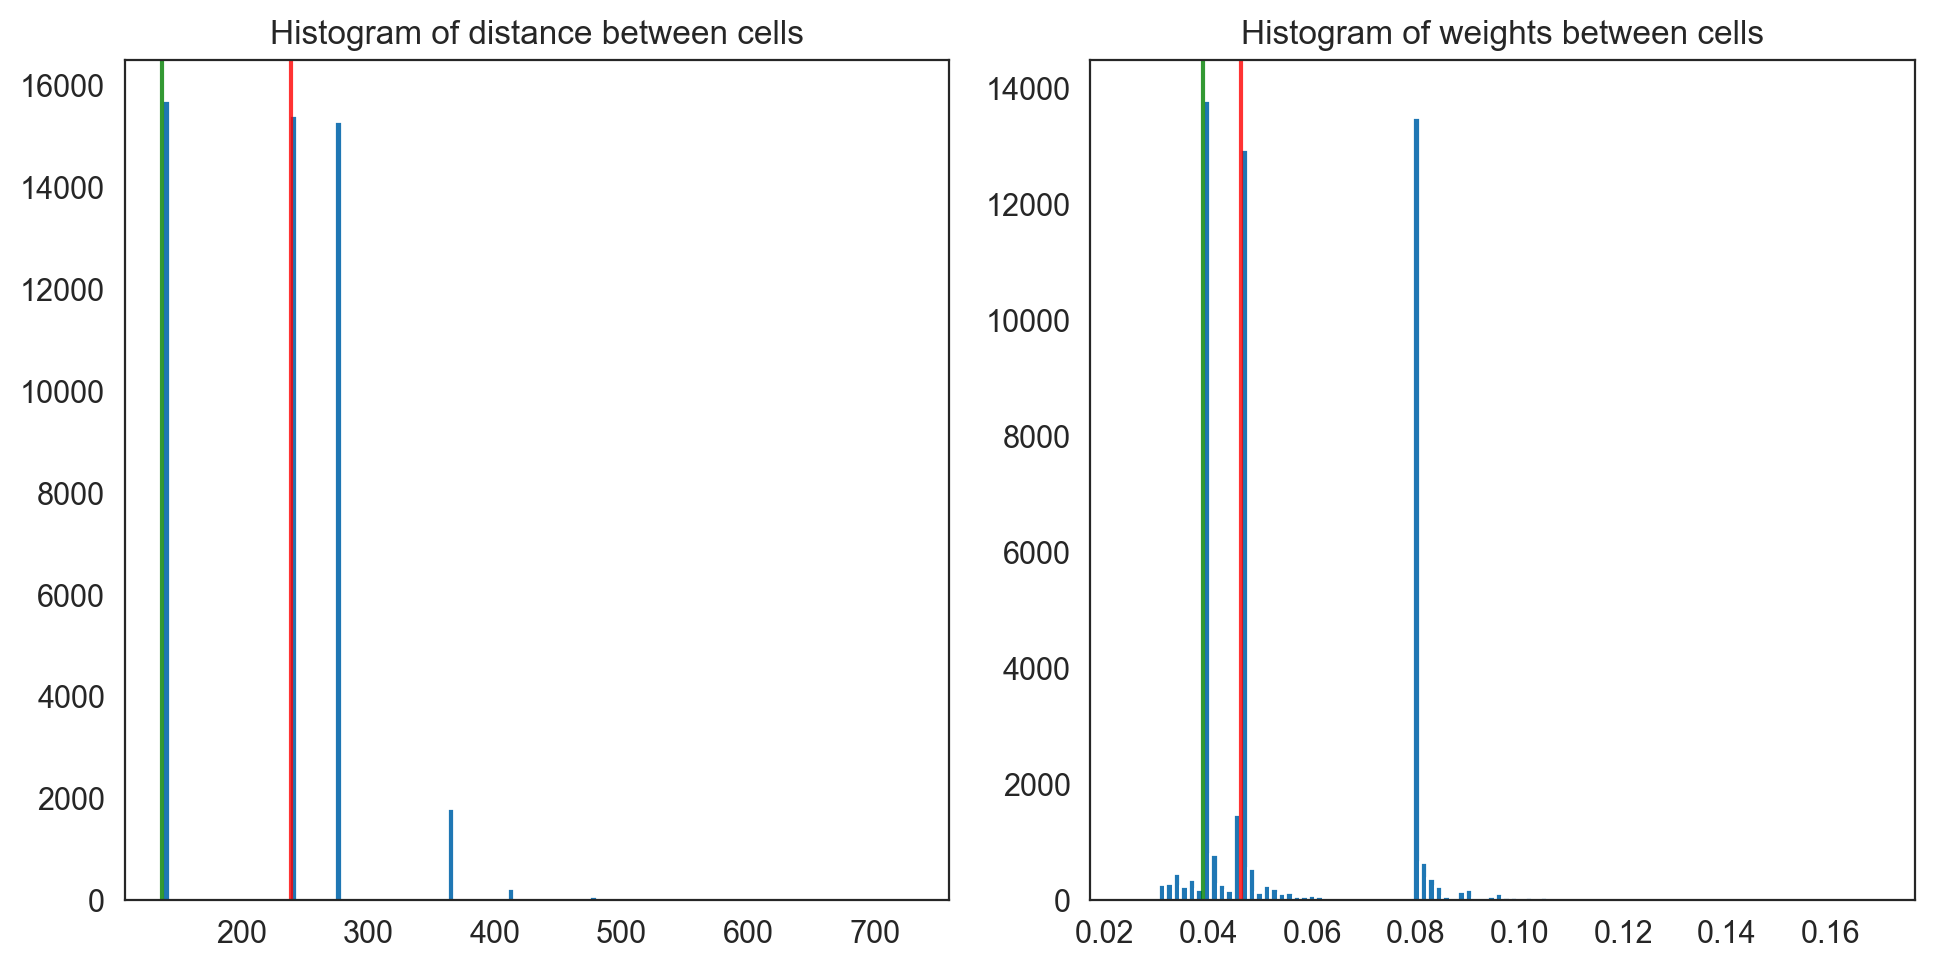

In [8]:
from sklearn.neighbors import NearestNeighbors
from banksy.main import generate_spatial_weights_fixed_nbrs
# 将细胞间距离以直方图的形式给出
from utils.plotting import plot_edge_histogram

num_neighbours = 18
sigmas = (-1, )
processing_dict = {}

nbrs = NearestNeighbors(algorithm='ball_tree').fit(adata.obsm['spatial'])
distances, indices = nbrs.kneighbors(n_neighbors=num_neighbours)
for sigma in sigmas:
    if sigma < 0:
        if sigma == -1:
            decay_type = 'reciprocal'
        elif sigma == -2:
            decay_type = 'ranked'
        elif sigma == -3:
            decay_type = 'uniform'
        else:
            raise ValueError('Type not recognised')

        weights_graph, distance_graph = generate_spatial_weights_fixed_nbrs(
            adata.obsm['spatial'],
            num_neighbours=num_neighbours,
            decay_type=decay_type,
            nbr_object=nbrs,
            verbose=False,
        )
    processing_dict[sigma] = {'weights': weights_graph}
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    plot_edge_histogram(distance_graph, ax[0], title='distance between cells')
    plot_edge_histogram(weights_graph, ax[1], title='weights between cells')
    fig.tight_layout()

print(processing_dict)

Maximum weight: 0.1690352314230381

---- Ran plot_graph_weights in 0.80 s ----



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


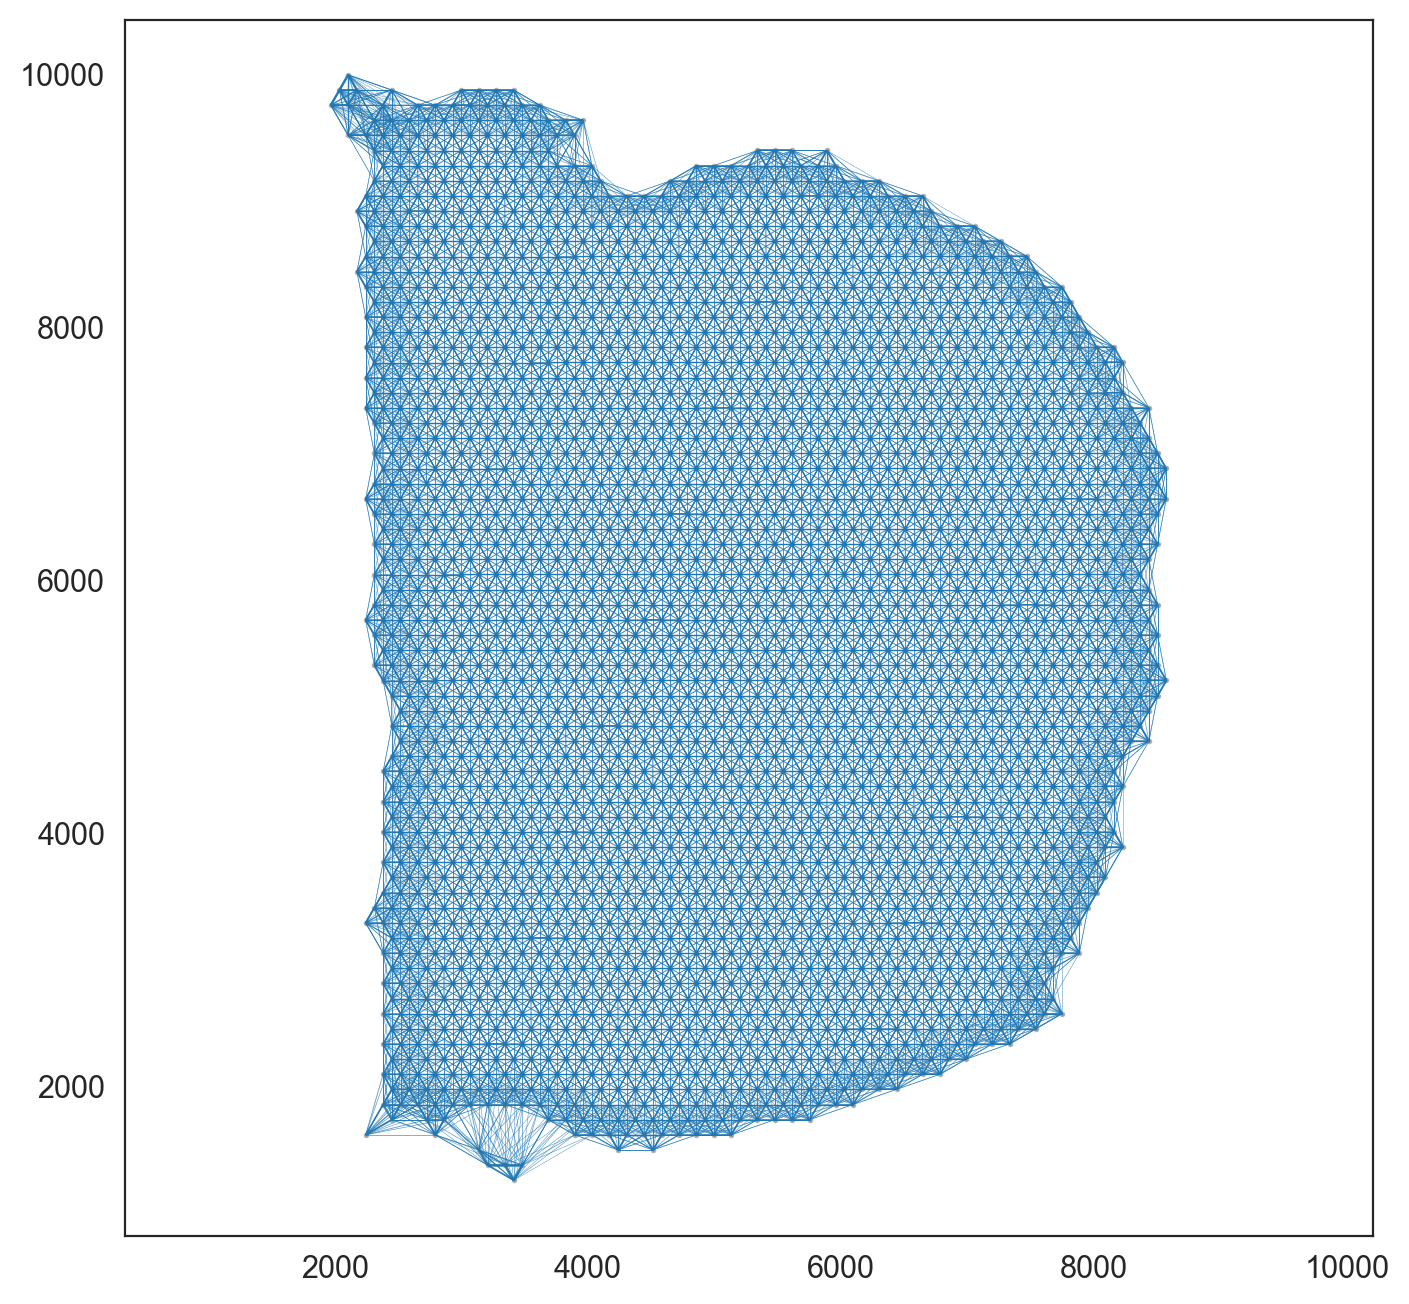

In [9]:
# draw spatial neighbor network
# 在整个组织图背景下，绘制近邻网络结构图
from utils.plotting import plot_graph_weights
plot_graph_weights(
    adata.obsm['spatial'],
    weights_graph,
    max_weight=1,
    markersize=1,
    figsize=(8, 8),
)
ax = plt.gca()
ax.axis('equal')
plt.savefig('mouse_poster_ana.eps', dpi=200, format='eps', bbox_inches='tight')

-1 {'weights': <2702x2702 sparse matrix of type '<class 'numpy.float64'>'
	with 48636 stored elements in Compressed Sparse Row format>}

Cell by gene matrix (<class 'anndata._core.views.SparseCSRView'>) has shape (2702, 3000)
Normalized spatial weights graph adjacency matrix has shape (2702, 2702)
Aggregated Neighbours matrix has shape (2702, 3000)

---- Ran weighted_concatenate in 0.06 s ----

(2702, 6000)
(6000,)
num_nbrs: 3000
AnnData object with n_obs × n_vars = 2702 × 6000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'is_nbr'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'
---- Ran weighted_concatenate in 0.05 s ----

(2702, 6000)
(6000,)
num_nbrs: 3000
AnnData object with n_obs × n_vars = 2702 × 6000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_

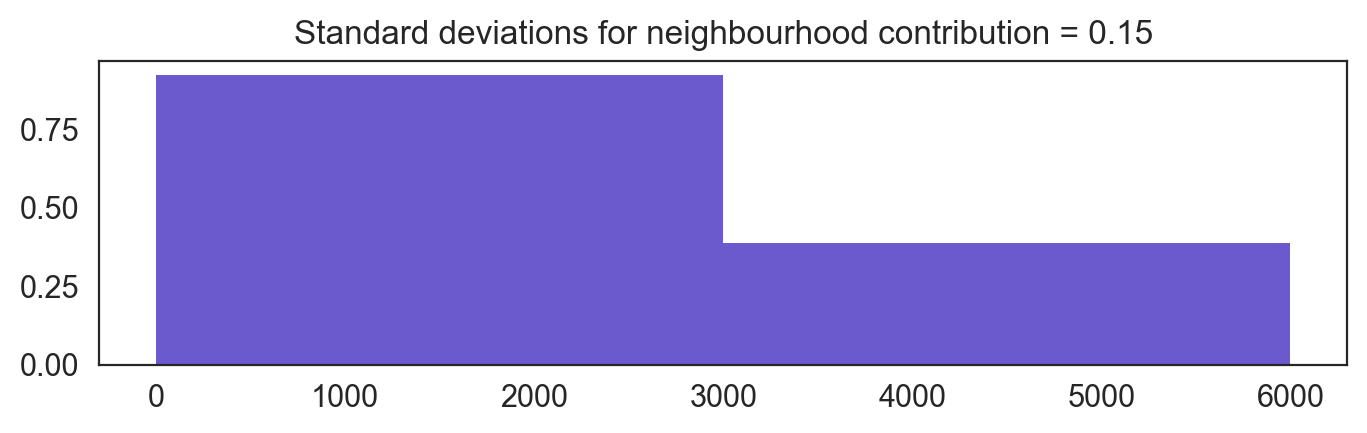

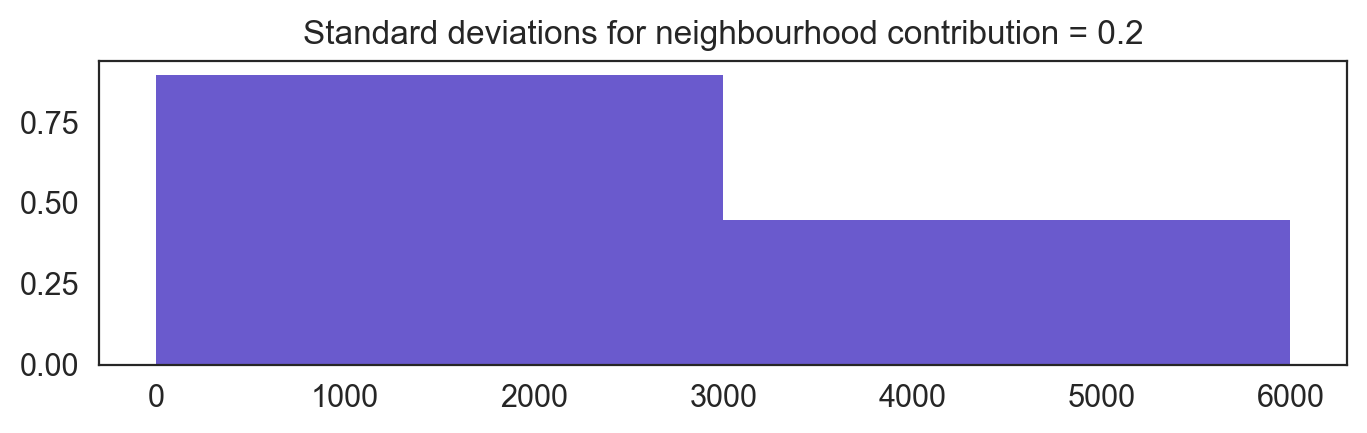

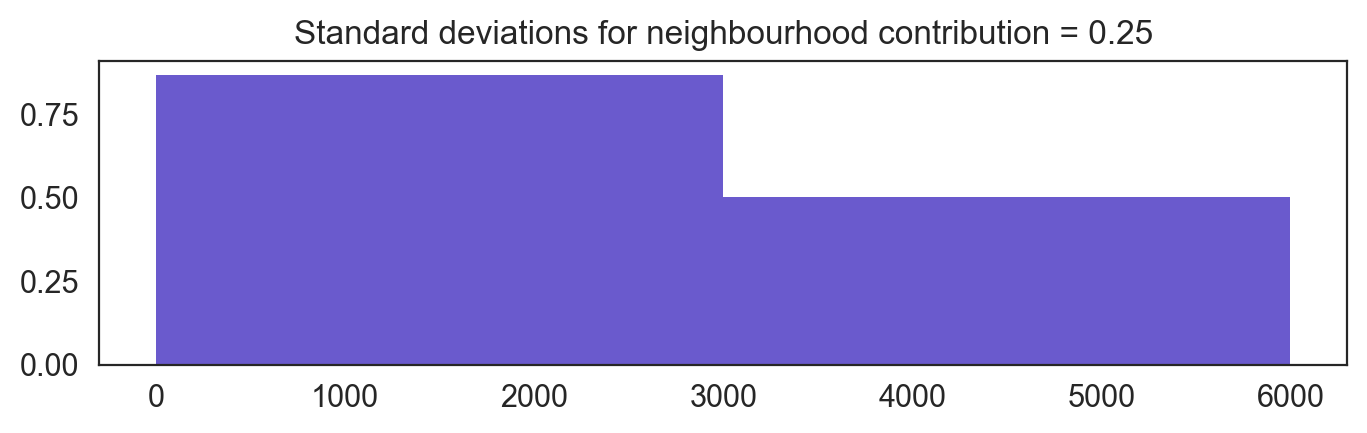

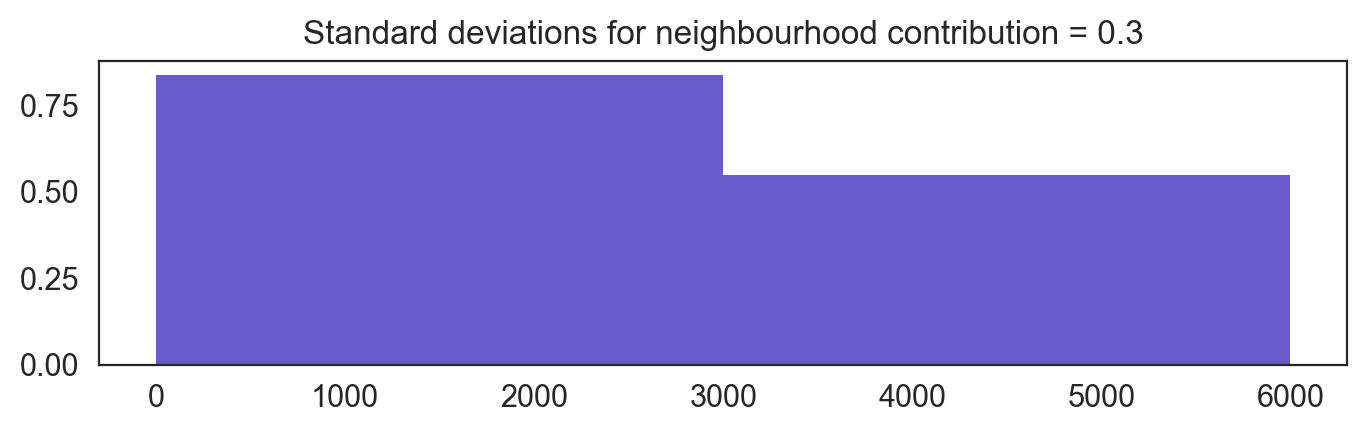

In [10]:
from utils.cluster import matrix_to_adata
from banksy.main import zscore, weighted_concatenate


gene_list = adata.var.index
# 该参数，控制邻域节点对当前节点的基因表达影响程度，越大说明越多
nbrhood_contributions = [0.15, 0.2, 0.25, 0.3]
for sigma in processing_dict:
    print(sigma, processing_dict[sigma])

    weights = processing_dict[sigma]['weights']
    neighbour_agg_matrix = weights @ adata.X

    if sparse.issparse(adata.X):
        concatenated = sparse.hstack((adata.X, neighbour_agg_matrix), )
    else:
        concatenated = np.concatenate((adata.X, neighbour_agg_matrix), axis=1,)

    processing_dict[sigma]['norm_counts_concatenated'] = concatenated

    print(
        f"\nCell by gene matrix ({type(adata.X)}) has shape {adata.shape}\n"
        f"Normalized spatial weights graph adjacency matrix has shape {weights.shape}\n"
        f"Aggregated Neighbours matrix has shape {neighbour_agg_matrix.shape}\n"
    )
    for nbrhood_contribution in nbrhood_contributions:
        matrix = weighted_concatenate(
            zscore(adata.X, axis=0),
            zscore(neighbour_agg_matrix, axis=0),
            nbrhood_contribution
        )

        # no_normalize_matrix = weighted_concatenate(adata.X, neighbour_agg_matrix, nbrhood_contribution)
        print(matrix.shape)

        if sparse.issparse(matrix):
            st_dev_pergene = matrix.toarray().std(axis=0)
        else:
            st_dev_pergene = matrix.std(axis=0)

        print(st_dev_pergene.shape)
        fig, ax = plt.subplots(figsize=(8,2))
        ax.bar(np.arange(len(st_dev_pergene)), st_dev_pergene,
               width=1, color = 'slateblue', linewidth=0)
        ax.set_title(f"Standard deviations for neighbourhood contribution = {nbrhood_contribution}")

        new_adata = matrix_to_adata(matrix, adata)
        print(new_adata)
        # 将最终需要处理的adata保存进字典中，索引为dict[-1][0.2]
        processing_dict[sigma][nbrhood_contribution] = {'adata': new_adata,}

print_max_min(adata)
new_adata = adata.copy()
new_adata.X = zscore(new_adata.X, axis=0)

processing_dict[0] = {0.0: {'adata': new_adata, }}

In [11]:
weights_adj = processing_dict[-1]['weights'].toarray()
temp_adata = processing_dict[-1][0.25]['adata']

In [12]:
sc.pp.pca(temp_adata, n_comps=50)
# sc.pp.neighbors(temp_adata, n_neighbors=15)
# sc.tl.umap(temp_adata)

computing PCA
    with n_comps=50
    finished (0:00:01)


In [13]:
import numpy as np
dim = 21
def min_max_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# 对数据进行 Min-Max 归一化
count_sub = np.apply_along_axis(min_max_normalize, 0, temp_adata.obsm['X_pca'])
# count_sub =expression


In [14]:
import numpy as np


def Ge(n):
    """Creates a Gaussian Exponential matrix.

    Args:
        n: The size of the matrix.

    Returns:
        A n x n matrix with values ranging from 0.1 to 0.2.
    """

    # Define the decay factor
    decay_factor = 0.01

    # Create a n x n matrix and initialize all elements to 0
    mat_Ge = np.zeros((n, n))

    # Fill the diagonal elements with 1
    np.fill_diagonal(mat_Ge, 1)

    # Calculate the distance matrix
    dist_matrix = np.abs(np.outer(np.arange(1, n + 1), np.arange(1, n + 1)) - 1)

    # Calculate the decayed values using the exponential function
    mat_Ge = np.exp(-decay_factor * dist_matrix)

    # Adjust the range to 0.1 to 0.2
    mat_Ge = (mat_Ge - np.min(mat_Ge)) / (np.max(mat_Ge) - np.min(mat_Ge)) * 0.1

    # Ensure diagonal elements are 1
    np.fill_diagonal(mat_Ge, 1)

    return mat_Ge

In [15]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
spatia_init_tensor = torch.from_numpy(weights_graph.A).float().to(device)
x_tensor = torch.from_numpy(temp_adata.obsm['X_pca'].T).to(device)

In [16]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
import numpy as np

def svd(mat, k):
    # 使用 TruncatedSVD 进行截断 SVD 分解
    svd = TruncatedSVD(n_components=k)
    u_k = svd.fit_transform(mat)
    s_k = np.diag(svd.singular_values_)
    vt_k = svd.components_

    return u_k, s_k, vt_k

def svd_sparse(mat, k):
    # 使用 scipy 的 svds 进行截断 SVD 分解
    u_k, s_k, vt_k = svds(mat, k=k)

    return u_k, np.diag(s_k), vt_k

# 对 count_sub 进行奇异值分解
svd_result_x = svd(np.transpose(count_sub), dim)
mat_be = np.abs(svd_result_x[0] @ np.sqrt(svd_result_x[1]))
mat_ge = Ge(dim)
mat_fe = np.abs(np.sqrt(svd_result_x[1]) @ svd_result_x[2])

# 对 temp_adata.obsp['connectivities'] 进行奇异值分解
svd_result_k = svd_sparse(weights_graph, dim)
mat_bs = np.abs(svd_result_k[0] @ np.sqrt(svd_result_k[1]))
mat_gs = Ge(dim)
mat_fs = np.abs(np.sqrt(svd_result_k[1]) @ svd_result_k[2])


In [17]:


from sklearn.metrics.pairwise import cosine_similarity
from ST_SCSR import  ST_SCSR

max_epoch = 20

n_spot = count_sub.shape[0]
n_neighbor = 30
init_W = cosine_similarity(count_sub)
cos_init = np.zeros((n_spot, n_spot))
for i in range(n_spot):
    vec = init_W[i, :]
    distance = vec.argsort()[:: -1]
    for t in range(n_neighbor + 1):
        y = distance[t]
        cos_init[i, y] = init_W[i, y]
cos_init_tensor = torch.from_numpy(cos_init).float().to(device)
# result = join_nmf1(np.transpose(count_sub), mat_be, mat_Ge, mat_fe,  max_epoch)
# result = join_nmf_2(np.transpose(count_sub), mat_be, mat_ge, mat_fe, mat_bs,  mat_fs, spatial_network.toarray(), max_epoch)
# result = join_nmf(np.transpose(count_sub), mat_be, mat_Ge, mat_fe, mat_bs, mat_Gs, mat_fs, spatial_network.toarray(), max_epoch)
result = ST_SCSR(np.transpose(count_sub), mat_be, mat_ge, mat_fe, mat_bs, mat_fs, weights_graph.toarray(), max_epoch,cos_init)
# result = join_nmf_4(np.transpose(count_sub), mat_be, mat_ge, mat_fe, mat_bs, mat_fs, spatial_network.toarray(), max_epoch,cos_init)


##err1  0 is:  147.9386804589831
##err2  0 is:  79.57331131914279
##err3  0 is:  43.690766666160116
##err4  0 is:  553.5542237043858
##err1  1 is:  34.60361692960954
##err2  1 is:  12.822239506484257
##err3  1 is:  37.04827545060339
##err4  1 is:  308.4254502884752
##err1  2 is:  30.133477166549334
##err2  2 is:  12.822214972919841
##err3  2 is:  32.74742966247166
##err4  2 is:  157.25227806273068
##err1  3 is:  28.63130709447849
##err2  3 is:  12.823404401051969
##err3  3 is:  29.785746966397625
##err4  3 is:  73.4428348346659
##err1  4 is:  27.82225780029558
##err2  4 is:  12.836440861464396
##err3  4 is:  27.506780523407986
##err4  4 is:  33.27813525798805
##err1  5 is:  27.31257362880047
##err2  5 is:  12.874655916455353
##err3  5 is:  25.652057903698076
##err4  5 is:  16.32400207157358
##err1  6 is:  26.966484296161454
##err2  6 is:  12.888784670875634
##err3  6 is:  24.09422864536631
##err4  6 is:  9.660568087490452
##err1  7 is:  26.720539861605577
##err2  7 is:  12.893624993355

In [18]:
temp_adata

AnnData object with n_obs × n_vars = 2702 × 6000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'is_nbr'
    uns: 'spatial', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'

running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


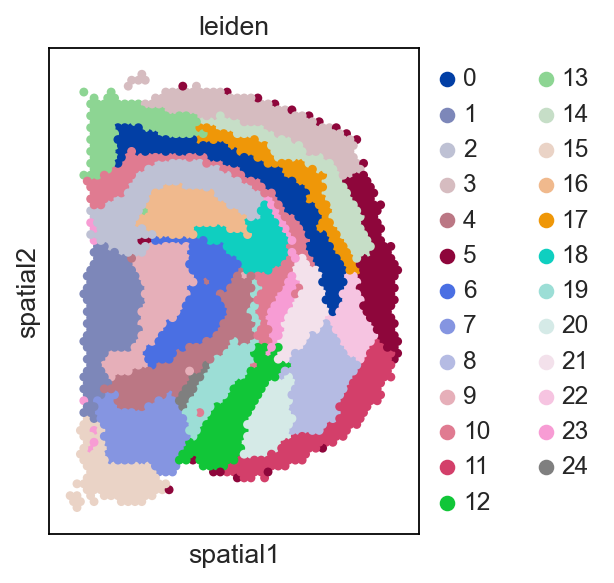

In [20]:
sc.tl.leiden(temp_adata, resolution=1)
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200, frameon=True, vector_friendly=False, fontsize=12, figsize=None, color_map=None, format='eps', facecolor=None, transparent=True, ipython_format='png2x')
# sc.pl.spatial(temp_adata, color=['leiden'], size=1.8, alpha_img=0, save='mouse_coronal')
sc.pl.spatial(temp_adata, color=['leiden'], alpha_img=0, size=2)